In [ ]:
pip install earthengine-api

In [ ]:
import ee
ee.Authenticate()
ee.Initialize(project='ee-saadlkhder02')

In [ ]:
# Définir la région Fès-Meknès (rectangle approximatif)
roi_fes_meknes = ee.Geometry.Rectangle([-5.8, 33.0, -3.0, 34.5])

# Définir la période
start_date = "2018-01-01"
end_date = "2025-04-05"


In [ ]:
# Load Landsat 8 imagery
landsat = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR") \
    .filterBounds(roi_fes_meknes) \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.lt("CLOUD_COVER", 10))  # Filter out cloudy images

# Function to calculate NDVI
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(["B5", "B4"]).rename("NDVI")
    return image.addBands(ndvi)

# Apply the NDVI function to the image collection
landsat_ndvi = landsat.map(calculate_ndvi)

/usr/local/lib/python3.11/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for LANDSAT/LC08/C01/T1_SR! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/reference/removed_datasets#landsat_collection_1

  warnings.warn(warning, category=DeprecationWarning)


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
# Charger la collection Landsat 8
landsat = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
    .filterBounds(roi_fes_meknes) \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.lt("CLOUD_COVER", 10))

# Vérifier si la collection contient des images
landsat_size = landsat.size().getInfo()
if landsat_size == 0:
    raise ValueError("Aucune image trouvée avec les critères de sélection.")

print(f"{landsat_size} images trouvées dans la collection")

# Fonction pour calculer le NDVI
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(["SR_B5", "SR_B4"]).rename("NDVI")
    return image.addBands(ndvi)

# Appliquer la fonction NDVI
landsat_ndvi = landsat.map(calculate_ndvi)

# Récupérer les données de NDVI
try:
    # Obtenir les informations de région (cette opération est asynchrone)
    ndvi_time_series = landsat_ndvi.getRegion(
        geometry=roi_fes_meknes,
        scale=100,
        crs='EPSG:4326'
    ).getInfo()  # getInfo() force l'exécution de la requête

    # Convertir en DataFrame pandas
    import pandas as pd
    headers = ndvi_time_series[0]
    data = ndvi_time_series[1:]
    df = pd.DataFrame(data, columns=headers)

    # Traitement des données
    df['time'] = pd.to_datetime(df['time'], unit='ms')
    df['NDVI'] = pd.to_numeric(df['NDVI'])
    df = df.dropna(subset=['NDVI'])

    # Sauvegarder
    df.to_csv("ndvi_time_series.csv", index=False)
    print("Fichier CSV créé avec succès")

except ee.EEException as e:
    print(f"Erreur Earth Engine: {str(e)}")
except Exception as e:
    print(f"Erreur inattendue: {str(e)}")
    import matplotlib.pyplot as plt
import pandas as pd



560 images trouvées dans la collection
Erreur Earth Engine: ImageCollection.getRegion: Too many values: 5205042 points x 20 bands x 560 images > 1048576.


Extraction NDVI: 100%|██████████| 540/540 [07:25<00:00,  1.21it/s]


✅ CSV exportés avec succès


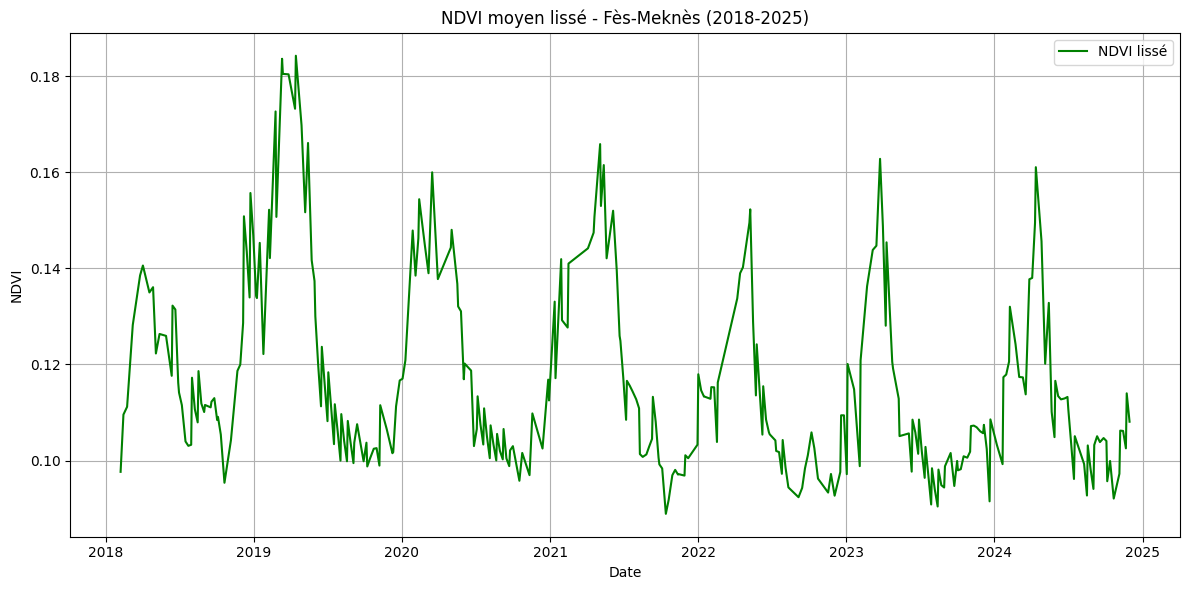

In [ ]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Initialiser Earth Engine


# Définir la géométrie approximative de Fès-Meknès
roi_fes_meknes = ee.Geometry.Rectangle([-5.8, 33.0, -3.0, 34.5])

# Définir la période
start_date = "2018-01-01"
end_date = "2025-01-01"

# Charger la collection Landsat 8
landsat = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
    .filterBounds(roi_fes_meknes) \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.lt("CLOUD_COVER", 10))

# Fonction pour calculer NDVI moyen pour chaque image
def get_ndvi_feature(image):
    ndvi = image.normalizedDifference(["SR_B5", "SR_B4"]).rename("NDVI")
    date = image.date().format("YYYY-MM-dd")
    mean_dict = ndvi.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi_fes_meknes,
        scale=100,
        maxPixels=1e9
    )
    return ee.Feature(None, {
        'date': date,
        'NDVI': mean_dict.get('NDVI')
    })

# Appliquer la fonction à chaque image
ndvi_fc = landsat.map(get_ndvi_feature)

# Extraire la liste de Features
features = ndvi_fc.toList(ndvi_fc.size())
ndvi_data = []
for i in tqdm(range(features.size().getInfo()), desc="Extraction NDVI"):
    f = ee.Feature(features.get(i)).getInfo()
    props = f['properties']
    if 'NDVI' in props and props['NDVI'] is not None:
        ndvi_data.append({
            'date': props['date'],
            'NDVI': props['NDVI']
        })

# Créer un DataFrame propre
df = pd.DataFrame(ndvi_data)
df["date"] = pd.to_datetime(df["date"])
df["NDVI"] = pd.to_numeric(df["NDVI"], errors="coerce")
df = df.dropna()

# Regrouper par date (au cas où il y a plusieurs NDVI par jour)
df_mean = df.groupby("date").mean().reset_index()

# Ajouter un lissage (moyenne mobile)
df_mean["NDVI_smoothed"] = df_mean["NDVI"].rolling(window=5, center=True).mean()

# Sauvegarder les deux CSV
df.to_csv("ndvi_raw_fes_meknes.csv", index=False)
df_mean.to_csv("ndvi_grouped_smoothed_fes_meknes.csv", index=False)
print("✅ CSV exportés avec succès")

# Tracer la courbe lissée
plt.figure(figsize=(12, 6))
plt.plot(df_mean["date"], df_mean["NDVI_smoothed"], color="green", label="NDVI lissé")
plt.title("NDVI moyen lissé - Fès-Meknès (2018-2025)")
plt.xlabel("Date")
plt.ylabel("NDVI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("ndvi_lisse_fes_meknes.png")
plt.show()


In [ ]:
!pip install folium --upgrade # Upgrade to the latest version of folium

In [ ]:

import ee
import geemap
import branca.colormap as cm
import folium
from folium import plugins


# Définir la région Fès-Meknès (rectangulaire)
roi_fes_meknes = ee.Geometry.Rectangle([-5.8, 33.0, -3.0, 34.5])

# Charger la collection Landsat 8 filtrée
landsat = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
    .filterBounds(roi_fes_meknes) \
    .filterDate("2018-01-01", "2025-01-01") \
    .filter(ee.Filter.lt("CLOUD_COVER", 10))

# Calcul NDVI
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(["SR_B5", "SR_B4"]).rename("NDVI")
    return image.addBands(ndvi)

landsat_ndvi = landsat.map(calculate_ndvi)

# Image NDVI médiane
median_ndvi = landsat_ndvi.median().select('NDVI')

# Palette de couleurs
ndvi_palette = ['red', 'yellow', 'green']
colormap = cm.LinearColormap(
    ndvi_palette,
    vmin=0,
    vmax=1,
    caption='NDVI'
)

# Carte interactive centrée sur la zone
map_center = roi_fes_meknes.centroid().coordinates().getInfo()[::-1]
m = geemap.Map(location=map_center, zoom_start=8)

# Visualisation NDVI
ndvi_vis = {
    'min': 0,
    'max': 1,
    'palette': ndvi_palette
}

# Ajouter la couche NDVI
m.addLayer(median_ndvi, ndvi_vis, 'NDVI Médian')

# Ajouter les contrôles
m.add_colorbar(
    vis_params=ndvi_vis,
    label='NDVI',
    layer_name='NDVI Médian'
)
m.addLayerControl()
m.add_control(folium.plugins.MiniMap())
m.add_control(folium.plugins.Fullscreen())

# Afficher la carte
display(m)


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
!pip install pillow
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from PIL import Image
import requests # Import the requests library

# Générer l'URL de l'image
url = median_ndvi.getThumbUrl({
    'min': 0,
    'max': 1,
    'palette': 'red,yellow,green',
    'dimensions': 800,
    'region':roi_fes_meknes
})

# Open the image using Pillow library
image = Image.open(requests.get(url, stream=True).raw)

# Afficher avec barre de couleur
fig, ax = plt.subplots(figsize=(12, 8))
# Display the image using Pillow's image object
img = plt.imshow(np.array(image)) # Convert the image to a NumPy array
plt.axis('off')

# Ajout barre de couleur
cbar = plt.colorbar(img, fraction=0.03, pad=0.04)
cbar.set_label('NDVI Scale', rotation=270, labelpad=15)
plt.title('Carte NDVI - Région de Souss', pad=20)

plt.tight_layout()
plt.savefig('ndvi_color_map.png', dpi=300, bbox_inches='tight')
plt.show()

NameError: name 'roi_souss' is not defined

In [ ]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm


roi_fes_meknes = ee.Geometry.Rectangle([-5.8, 33.0, -3.0, 34.5])
years = list(range(2018, 2026))  # 2018 à 2025 inclus

all_rh = []

for year in years:
    print(f"🔄 Traitement de l'année {year}")
    start = f"{year}-01-01"
    end = f"{year}-12-31"

    era5 = ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY") \
        .filterBounds(roi_fes_meknes) \
        .filterDate(start, end) \
        .filter(ee.Filter.calendarRange(12, 12, 'hour')) \
        .select(["temperature_2m", "dewpoint_temperature_2m"])

    def compute_relative_humidity(image):
        temp = image.select("temperature_2m").subtract(273.15)
        dew = image.select("dewpoint_temperature_2m").subtract(273.15)
        es = temp.multiply(17.625).divide(temp.add(243.04)).exp()
        ed = dew.multiply(17.625).divide(dew.add(243.04)).exp()
        rh = ed.divide(es).multiply(100).rename("RH")

        mean_rh = rh.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=roi_fes_meknes,
            scale=1000,
            maxPixels=1e9
        )

        return ee.Feature(None, {
            "date": image.date().format("YYYY-MM-dd"),
            "RH": mean_rh.get("RH")
        })

    rh_fc = era5.map(compute_relative_humidity)
    features = rh_fc.toList(rh_fc.size())
    for i in tqdm(range(features.size().getInfo()), desc=f"Année {year}"):
        f = ee.Feature(features.get(i)).getInfo()
        props = f["properties"]
        if "RH" in props and props["RH"] is not None:
            all_rh.append({
                "date": props["date"],
                "RH": props["RH"]
            })

# Convertir en DataFrame
df_rh = pd.DataFrame(all_rh)
df_rh["date"] = pd.to_datetime(df_rh["date"])
df_rh["RH"] = pd.to_numeric(df_rh["RH"], errors="coerce")
df_rh = df_rh.dropna()

# Sauvegarde
df_rh.to_csv("humidite_relative_fes_meknes.csv", index=False)
print("✅ Extraction terminée et CSV exporté.")

# Graphique
plt.figure(figsize=(12, 6))
plt.plot(df_rh["date"], df_rh["RH"], color="blue", label="RH quotidienne")
plt.title("Humidité relative quotidienne - Fès-Meknès (2018–2025)")
plt.xlabel("Date")
plt.ylabel("Humidité (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("humidite_relative_fes_meknes.png", dpi=300)
plt.show()


🔄 Traitement de l'année 2018


Année 2018: 100%|██████████| 364/364 [35:11<00:00,  5.80s/it]


🔄 Traitement de l'année 2019


Année 2019: 100%|██████████| 364/364 [35:34<00:00,  5.87s/it]


🔄 Traitement de l'année 2020


Année 2020: 100%|██████████| 365/365 [37:28<00:00,  6.16s/it]


🔄 Traitement de l'année 2021


Année 2021: 100%|██████████| 364/364 [36:57<00:00,  6.09s/it]


🔄 Traitement de l'année 2022


Année 2022: 100%|██████████| 364/364 [35:58<00:00,  5.93s/it]


🔄 Traitement de l'année 2023


Année 2023:  86%|████████▌ | 313/364 [30:56<04:31,  5.33s/it]

In [ ]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm


# Définir la région
roi_fes_meknes = ee.Geometry.Rectangle([-5.8, 33.0, -3.0, 34.5])

# Définir la période d'analyse
start_date = "2018-01-01"
end_date = "2025-01-01"

# Charger la collection CHIRPS
chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY") \
    .filterBounds(roi_fes_meknes) \
    .filterDate(start_date, end_date) \
    .select("precipitation")

# Fonction pour extraire la précipitation moyenne par image
def extract_daily_precip(image):
    date = image.date().format("YYYY-MM-dd")
    mean_rain = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi_fes_meknes,
        scale=5000,
        maxPixels=1e9
    )
    return ee.Feature(None, {
        "date": date,
        "precipitation": mean_rain.get("precipitation")
    })

# Appliquer la fonction à chaque image
rain_fc = chirps.map(extract_daily_precip)

# Extraire les données
features = rain_fc.toList(rain_fc.size())
rain_data = []
for i in tqdm(range(features.size().getInfo()), desc="Extraction précipitations"):
    f = ee.Feature(features.get(i)).getInfo()
    props = f["properties"]
    if "precipitation" in props and props["precipitation"] is not None:
        rain_data.append({
            "date": props["date"],
            "precipitation": props["precipitation"]
        })

# Convertir en DataFrame
df_rain = pd.DataFrame(rain_data)
df_rain["date"] = pd.to_datetime(df_rain["date"])
df_rain["precipitation"] = pd.to_numeric(df_rain["precipitation"], errors="coerce")
df_rain = df_rain.dropna()

# Sauvegarder le CSV
df_rain.to_csv("serie_precipitation_fes_meknes.csv", index=False)
print("Série temporelle des précipitations exportée")

# Tracer la courbe
plt.figure(figsize=(12, 6))
plt.plot(df_rain["date"], df_rain["precipitation"], color="blue", label="Précipitations quotidiennes (mm)")
plt.title("Série temporelle des précipitations - Fès-Meknès (2018–2025)")
plt.xlabel("Date")
plt.ylabel("Précipitation (mm)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("serie_precipitation_fes_meknes.png", dpi=300)
plt.show()


In [ ]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Définir la région Fès-Meknès
roi_fes_meknes = ee.Geometry.Rectangle([-5.8, 33.0, -3.0, 34.5])

# Définir la période
start_date = "2018-01-01"
end_date = "2025-01-01"

# Charger ERA5-Land à 12h (UTC)
era5 = ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY") \
    .filterBounds(roi_fes_meknes) \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.calendarRange(12, 12, 'hour')) \
    .select("temperature_2m")  # Température à 2m en Kelvin

# Fonction pour extraire la température moyenne par jour
def extract_daily_temp(image):
    date = image.date().format("YYYY-MM-dd")
    temp_c = image.select("temperature_2m").subtract(273.15)  # Convertir en °C
    mean_temp = temp_c.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi_fes_meknes,
        scale=1000,
        maxPixels=1e9
    )
    return ee.Feature(None, {
        "date": date,
        "temperature": mean_temp.get("temperature_2m")
    })

# Appliquer la fonction à chaque image
temp_fc = era5.map(extract_daily_temp)

# Extraire les données
features = temp_fc.toList(temp_fc.size())
temp_data = []
for i in tqdm(range(features.size().getInfo()), desc="Extraction température"):
    f = ee.Feature(features.get(i)).getInfo()
    props = f["properties"]
    if "temperature" in props and props["temperature"] is not None:
        temp_data.append({
            "date": props["date"],
            "temperature": props["temperature"]
        })

# Convertir en DataFrame
df_temp = pd.DataFrame(temp_data)
df_temp["date"] = pd.to_datetime(df_temp["date"])
df_temp["temperature"] = pd.to_numeric(df_temp["temperature"], errors="coerce")
df_temp = df_temp.dropna()

# Sauvegarder le CSV
df_temp.to_csv("serie_temperature_fes_meknes.csv", index=False)
print(" Série temporelle de température exportée")

# Tracer la courbe
plt.figure(figsize=(12, 6))
plt.plot(df_temp["date"], df_temp["temperature"], color="orange", label="Température (°C)")
plt.title("Série temporelle de la température - Fès-Meknès (2018–2025)")
plt.xlabel("Date")
plt.ylabel("Température (°C)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("serie_temperature_fes_meknes.png", dpi=300)
plt.show()


In [ ]:
import pandas as pd

# Charger chaque série temporelle
df_ndvi = pd.read_csv("ndvi_grouped_smoothed_fes_meknes.csv")
df_precip = pd.read_csv("serie_precipitation_fes_meknes.csv")
df_temp = pd.read_csv("serie_temperature_fes_meknes.csv")
# df_rh = pd.read_csv("humidite_relative_fes_meknes.csv")  # optionnel

# Convertir les dates en datetime
df_ndvi["date"] = pd.to_datetime(df_ndvi["date"])
df_precip["date"] = pd.to_datetime(df_precip["date"])
df_temp["date"] = pd.to_datetime(df_temp["date"])
# df_rh["date"] = pd.to_datetime(df_rh["date"])


In [ ]:
# Fusion NDVI + Précipitations
df_all = pd.merge(df_ndvi, df_precip, on="date", how="inner")

# Fusion avec Température
df_all = pd.merge(df_all, df_temp, on="date", how="inner")

# (Optionnel) Fusion avec Humidité
# df_all = pd.merge(df_all, df_rh, on="date", how="inner")
